In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.6, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.5, 1.0],
        grow_factor = [0.5, 1.0],
        scale_hyperparameter = False))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.rr = model.radioactive_rating[1] - (model.radioactive_rating[1] - model.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.gf = model.grow_factor[1] - (model.grow_factor[1] - model.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.crossover_rate = model.x_rate[1] - (model.x_rate[1] - model.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.mutation_rate = model.m_rate[0] + (model.m_rate[1] - model.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    '''
    

C:\Users\tcumi\github_repo\neural-network\python\ga.py:189: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.8395061728395061, Loss: 0.5960049099392362


C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 200, Accuracy: 0.8395061728395061, Loss: 0.5927114839907046
Checkpoint 300, Accuracy: 0.8641975308641975, Loss: 0.5906556094134295
Checkpoint 400, Accuracy: 0.8518518518518519, Loss: 0.600120191220884
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.5981726469816985


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for y in y_list:
        ax.plot(x, y)
    if x_label is not None and y_label is not None:
        title = '{} VS {}'.format(x_label, y_label)
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

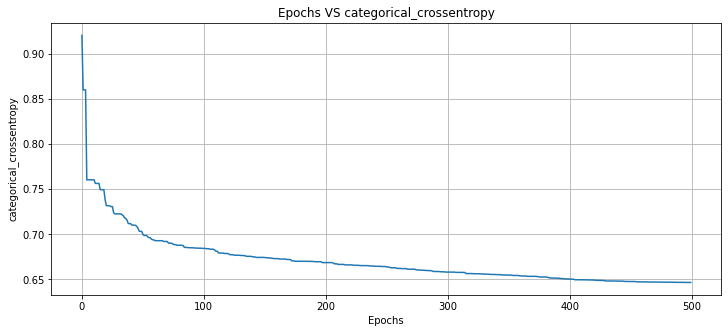

In [10]:
draw_plot(x = [i for i in range(len(history))], y_list = [history], x_label = 'Epochs', \
    y_label = model.loss_fn)

In [11]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 1. 0.] <-> [[0.7615381 ]
 [0.20069228]
 [0.03776957]]
[1. 0. 0.] <-> [[0.45776412]
 [0.2822183 ]
 [0.26001763]]
[0. 1. 0.] <-> [[0.5947738 ]
 [0.22819565]
 [0.17703053]]
[0. 1. 0.] <-> [[0.43216243]
 [0.2998457 ]
 [0.26799184]]
[1. 0. 0.] <-> [[0.8917574 ]
 [0.0949279 ]
 [0.01331474]]
[0. 1. 0.] <-> [[0.42043862]
 [0.3074341 ]
 [0.2721272 ]]
[0. 0. 1.] <-> [[0.07056446]
 [0.4272957 ]
 [0.5021398 ]]
[0. 0. 1.] <-> [[0.05970491]
 [0.42518547]
 [0.5151096 ]]
[0. 0. 1.] <-> [[0.20054574]
 [0.41214833]
 [0.387306  ]]
[1. 0. 0.] <-> [[0.8985435 ]
 [0.07510778]
 [0.02634877]]
[1. 0. 0.] <-> [[0.41464227]
 [0.31108874]
 [0.27426893]]
[1. 0. 0.] <-> [[0.5000355 ]
 [0.25016704]
 [0.24979748]]
[1. 0. 0.] <-> [[0.8983322 ]
 [0.06801514]
 [0.03365273]]
[1. 0. 0.] <-> [[0.8968371 ]
 [0.08377797]
 [0.01938493]]
[1. 0. 0.] <-> [[0.89474964]
 [0.03672275]
 [0.0685276 ]]
[1. 0. 0.] <-> [[0.22090454]
 [0.40542182]
 [0.37367362]]
[0. 1. 0.] <-> [[0.07797148]
 [0.42847162]
 [0.49355692]]
[1. 0. 0.] <->

C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


In [12]:
# Testing Performance

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8395061728395061, 'mean_square_error': 2.840353383382853, 'categorical_crossentropy': 0.5960049099392362, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 6, 'fp_hit': 13, 'tn_hit': 80, 'fn_hit': 9}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 100} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.8542234205082817, 'categorical_crossentropy': 0.5927114839907046, 'precision': 0.7592592592592593, 'recall': 0.7592592592592593, 'f1': 0.7592592592592593, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 14, 'tn_hit': 14, 'fn_hit': 3}, 1: {'tp_hit': 5, 'fp_hit': 12, 'tn_hit': 81, 'fn_hit': 10}, 2: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 13}}, 'checkpoint': 200} 


{'accuracy': 0.8641975308641975, 'mean_square_error': 2.8443989373696468, 'categorical_crossentropy': 0.5906556094134295, 'precision

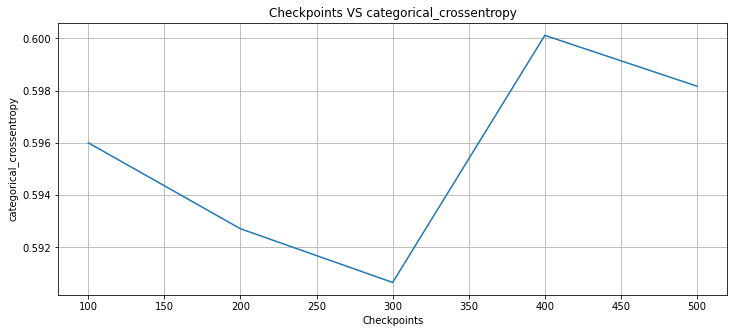

In [14]:
cat_cross = [ ckp[model.loss_fn] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [cat_cross], x_label = 'Checkpoints', \
    y_label = model.loss_fn)

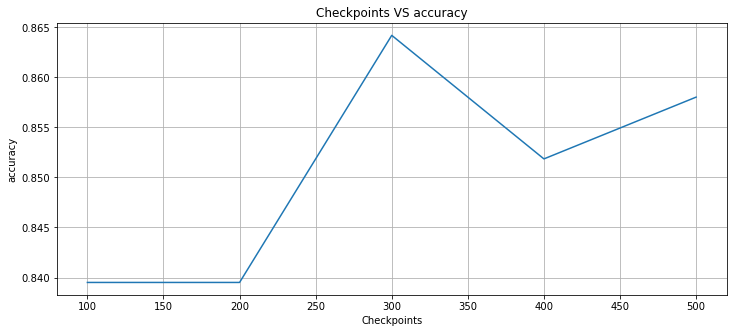

In [15]:
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [(i+1)*breakpoint for i in range(len(checkpoints))], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [16]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.44807023]
 [-1.4810511 ]
 [ 2.3854656 ]
 [-1.451656  ]
 [-1.40518   ]]
 bias: [3.]

Neuron 1: weights:
[[ 1.2838379 ]
 [-0.89108074]
 [ 1.0575843 ]
 [-1.7688696 ]
 [-0.43851525]]
 bias: [-1.3966445]

Neuron 2: weights:
[[-3.       ]
 [-3.       ]
 [-3.       ]
 [-1.8352903]
 [-3.       ]]
 bias: [-2.0344412]

Neuron 3: weights:
[[-0.6577548 ]
 [-0.00694348]
 [-2.3738844 ]
 [-1.5556197 ]
 [ 1.6473047 ]]
 bias: [-3.]

$
Layer 2
Neuron 0: weights:
[[ 1.0572891]
 [ 2.6038523]
 [ 3.       ]
 [-1.0625932]]
 bias: [-0.80340904]

Neuron 1: weights:
[[-1.0971781]
 [-2.492905 ]
 [ 2.3620205]
 [-1.0213414]]
 bias: [1.3662024]

Neuron 2: weights:
[[-1.8512055e+00]
 [ 1.1030749e-03]
 [-1.4999549e+00]
 [ 3.0000000e+00]]
 bias: [1.5710154]

$

